In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances


First, we load the dataset. Notice that only the ID column is not numeric, we can simply drop this one column and keep all others.

In [2]:
# Load dataset
df = pd.read_csv("hw2_dataset.csv")
# Drop ID column
df = df.drop(columns=['ID'])

Using the elbow method on a plot of inertia regarding to the number of clusters, we can determine the optimal k for k-means clustering. Here, we use k-means method to try using 1 to 30 clusters.

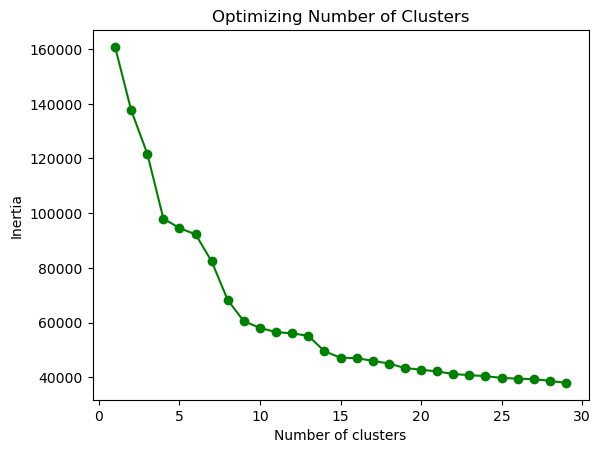

In [3]:
inertias = []
cluster_range = range(1, 30)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=1).fit(df)
    inertias.append(kmeans.inertia_)
plt.plot(cluster_range, inertias, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Optimizing Number of Clusters')
plt.show()

From the plot above, we can see the inertia decreases when there are more clusters. The elbow is at around k=9, which is the optimized number of cluster.

In [4]:
optimal_k = 9

With this given optimal k, we can cluster the data using different methods implemented in scikit-learn. In this project, we will use K-means clustering, hierarchical agglomerative clustering, and DBSCAN clustering.

In [12]:
# K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

# Hierarchical Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = agg_clust.fit_predict(df)

# DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=5)
dbscan_labels = dbscan.fit_predict(df)

/Users/zgt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Also, we can use different distance metrics. We will apply both the cosine distance and Jaccard distance in hierarchical agglomerative clustering, in comparison to the Euclidian distance we have already done above.

In [6]:
# Cosine distance
agg_cosine = AgglomerativeClustering(n_clusters=optimal_k, metric='cosine', linkage='average')
agg_cosine_labels = agg_cosine.fit_predict(df)

# Jaccard distance
jaccard_distance_matrix = pairwise_distances(df.to_numpy(), metric='jaccard')
agg_jaccard = AgglomerativeClustering(n_clusters=optimal_k, metric='precomputed', linkage='average')
agg_jaccard_labels = agg_jaccard.fit_predict(jaccard_distance_matrix)

/Users/zgt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


To visualize the results, we need to use dimension reducing techniques such as t-SNE.

In [7]:
# Reduce dimensions t-SNE
tsne = TSNE(n_components=2, random_state=1)
tsne_components = tsne.fit_transform(df)

Here we plot the three graphs to compare the results of three different methods of clustering.

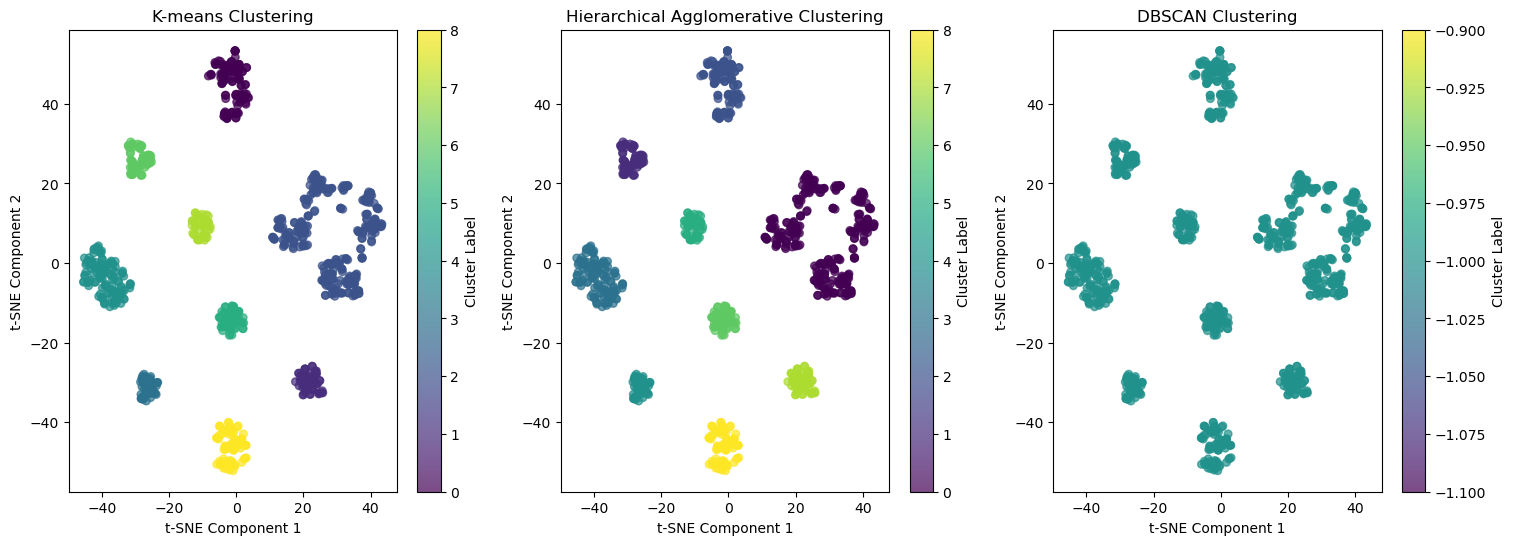

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# K-means Plot
scatter = axs[0].scatter(tsne_components[:, 0], tsne_components[:, 1], c=kmeans_labels, cmap='viridis', s=30, alpha=0.7)
axs[0].set_xlabel('t-SNE Component 1')
axs[0].set_ylabel('t-SNE Component 2')
axs[0].set_title('K-means Clustering')
fig.colorbar(scatter, ax=axs[0], label='Cluster Label')

# Hierarchical Agglomerative Plot
scatter = axs[1].scatter(tsne_components[:, 0], tsne_components[:, 1], c=hierarchical_labels, cmap='viridis', s=30, alpha=0.7)
axs[1].set_xlabel('t-SNE Component 1')
axs[1].set_ylabel('t-SNE Component 2')
axs[1].set_title('Hierarchical Agglomerative Clustering')
fig.colorbar(scatter, ax=axs[1], label='Cluster Label')

# DBSCAN Plot
scatter = axs[2].scatter(tsne_components[:, 0], tsne_components[:, 1], c=dbscan_labels, cmap='viridis', s=30, alpha=0.7)
axs[2].set_xlabel('t-SNE Component 1')
axs[2].set_ylabel('t-SNE Component 2')
axs[2].set_title('DBSCAN Clustering')
fig.colorbar(scatter, ax=axs[2], label='Cluster Label')

plt.show()


As we can see, both k-means and hierarchical agglomerative clustering work well, while DBSCAN clustering is problematic. Therefore, we can perform a grid search for the optimal values of eps and min_samples.

In [23]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Create a grid of parameters to try
eps_values = np.arange(1, 15, 0.1)
min_samples_values = range(2, 10)

best_score = -1
best_params = {'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df)
        
        
        if len(set(labels)) > 1:
            score = silhouette_score(df, labels)
            
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best Silhouette Score: {best_score}")
print(f"Optimal eps: {best_params['eps']}, Optimal min_samples: {best_params['min_samples']}")


Best Silhouette Score: 0.38963934132413114
Optimal eps: 9.699999999999998, Optimal min_samples: 3


The graph below shows the DBSCAN clustering with optimal parameters. Although the performance is still not as good as the other two, we can see a lot of correctly clustered data.

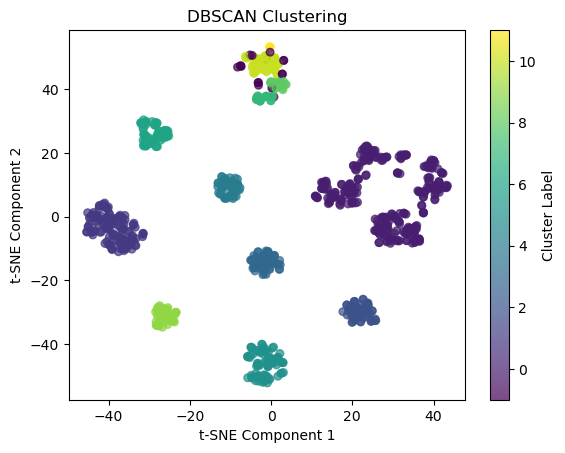

In [25]:
# DBSCAN clustering
dbscan = DBSCAN(eps=9.7, min_samples=3)  # optimized
dbscan_labels = dbscan.fit_predict(df)

# DBSCAN Plot
scatter = plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=dbscan_labels, cmap='viridis', s=30, alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('DBSCAN Clustering')
fig.colorbar(scatter, label='Cluster Label')

plt.show()

Finally, we plot for different distance metrics. The Euclidian distance works well, while the other two perform very similarly, combining too many distant data too within a single cluster, and also divided a cluster in t-SNE into too many clusters.

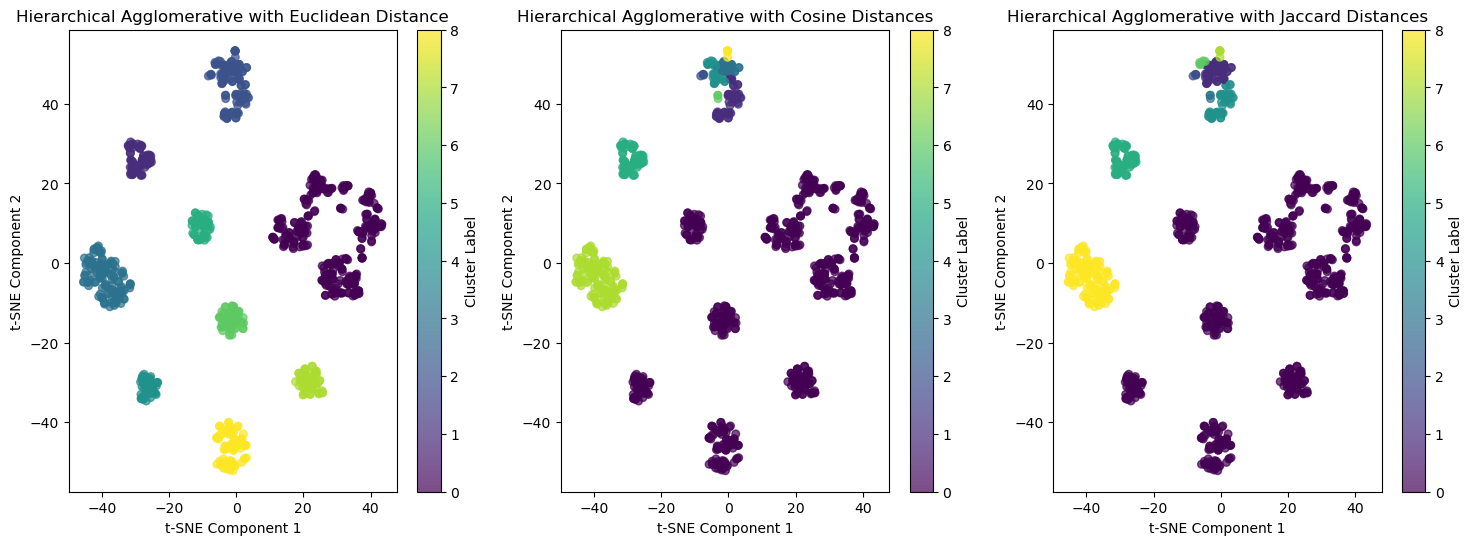

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Hierarchical Agglomerative
# Euclidean Distance Plot
scatter = axs[0].scatter(tsne_components[:, 0], tsne_components[:, 1], c=hierarchical_labels, cmap='viridis', s=30, alpha=0.7)
axs[0].set_xlabel('t-SNE Component 1')
axs[0].set_ylabel('t-SNE Component 2')
axs[0].set_title('Hierarchical Agglomerative with Euclidean Distance')
fig.colorbar(scatter, ax=axs[0], label='Cluster Label')

# Cosine Distance Plot
scatter = axs[1].scatter(tsne_components[:, 0], tsne_components[:, 1], c=agg_cosine_labels, cmap='viridis', s=30, alpha=0.7)
axs[1].set_xlabel('t-SNE Component 1')
axs[1].set_ylabel('t-SNE Component 2')
axs[1].set_title('Hierarchical Agglomerative with Cosine Distances')
fig.colorbar(scatter, ax=axs[1], label='Cluster Label')

# Jaccard Distance Plot
scatter = axs[2].scatter(tsne_components[:, 0], tsne_components[:, 1], c=agg_jaccard_labels, cmap='viridis', s=30, alpha=0.7)
axs[2].set_xlabel('t-SNE Component 1')
axs[2].set_ylabel('t-SNE Component 2')
axs[2].set_title('Hierarchical Agglomerative with Jaccard Distances')
fig.colorbar(scatter, ax=axs[2], label='Cluster Label')

plt.show()

Conclusion: K-means and hierarchical agglomerative clustering with Euclidean distance provide well-separated clusters, as expected given their reliance on centroid-based and distance-based hierarchical methods, respectively.

Hierarchical agglomerative clustering with cosine distance performs similarly, grouping points based on angular similarity, which is useful when the magnitude of the data is less important than its directional relationships. However, when switching to Jaccard distance, the clustering outcome changes, as Jaccard distance measures the similarity between binary attributes, which may not capture the data structure as effectively.

Finally, DBSCAN struggles with the dataset's structure, identifying a few core points while leaving many as noise. The t-SNE projections also show that DBSCAN's clusters are less distinct, which can be rationalized by its effectiveness on datasets with different characteristics. It is better for datasets with clusters of varying density, which may not align well with the structure of this data.